In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [109]:
df_train = pd.read_csv('train.csv', skipinitialspace=True)

df_test = pd.read_csv('test.csv', skipinitialspace=True)

## Data transformation

In [110]:
genres = df_train['genre'].unique()
# creo un dizionario per tenerli associati ad un numero
genres_dict = dict(zip(genres, range(len(genres))))
# Mappo i generi con i numeri
df_train['genre'] = df_train['genre'].map(genres_dict)
df_test['genre'] = df_test['genre'].map(genres_dict)
print(genres_dict)

{'j-dance': 0, 'iranian': 1, 'black-metal': 2, 'bluegrass': 3, 'happy': 4, 'industrial': 5, 'j-idol': 6, 'spanish': 7, 'sleep': 8, 'techno': 9, 'mandopop': 10, 'afrobeat': 11, 'disney': 12, 'study': 13, 'indian': 14, 'idm': 15, 'forro': 16, 'chicago-house': 17, 'brazil': 18, 'breakbeat': 19}


In [96]:
df_train['explicit'] = df_train['explicit'].astype(int)
df_test['explicit'] = df_test['explicit'].astype(int)

In [111]:
#Calculating only for the missing values in time_signature column by dividing n_beats/n_bars and rounding the result
df_train.loc[df_train['time_signature'].isna(), 'time_signature'] = round(df_train['n_beats'] / df_train['n_bars'])

df_test.loc[df_test['time_signature'].isna(), 'time_signature'] = round(df_test['n_beats'] / df_test['n_bars'])

StandarScaler normalization

In [45]:
from sklearn.preprocessing import StandardScaler

numerical_cols_train = df_train.select_dtypes(include=[np.number]).columns
numerical_cols_test = df_test.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

scaler.fit(df_train[numerical_cols_train])

scaled_numerical_train = scaler.transform(df_train[numerical_cols_train])
scaled_numerical_test = scaler.transform(df_test[numerical_cols_test])

df_train[numerical_cols_train] = scaled_numerical_train
df_test[numerical_cols_test] = scaled_numerical_test

MinMax normalization

In [112]:
from sklearn.preprocessing import MinMaxScaler

numerical_cols_train = df_train.select_dtypes(include=[np.number]).columns
numerical_cols_test = df_test.select_dtypes(include=[np.number]).columns


scaler = MinMaxScaler()

scaler.fit(df_train[numerical_cols_train])

scaled_numerical_train = scaler.transform(df_train[numerical_cols_train])
scaled_numerical_test = scaler.transform(df_test[numerical_cols_test])

df_train[numerical_cols_train] = scaled_numerical_train
df_test[numerical_cols_test] = scaled_numerical_test

In [113]:
#Dropping popularity confidence column
df_train.drop(columns=['popularity_confidence'], axis=1, inplace=True)
df_test.drop(columns=['popularity_confidence'], axis=1, inplace=True)

In [114]:
# Load your dataset
df_copy = df_train.copy()
df_copy_test = df_test.copy()

# Drop unnecessary columns
columns_to_drop = ['name', 'artists', 'album_name', 'explicit']
df_copy.drop(columns=columns_to_drop, axis=1, inplace=True)
df_copy_test.drop(columns=columns_to_drop, axis=1, inplace=True)


# Divide the dataset: one with known mode and one with missing mode
data_with_mode = df_copy.dropna(subset=['mode'])
data_missing_mode = df_copy[df_copy['mode'].isna()]
data_missing_mode_test = df_copy_test[df_copy_test['mode'].isna()]

# Features and target variable for the known 'mode'
X_known = data_with_mode.drop(columns=['mode'])
y_known = data_with_mode['mode']

# Features for the rows with missing 'mode'
X_missing = data_missing_mode.drop(columns=['mode'])
X_missing_test = data_missing_mode_test.drop(columns=['mode'])

# Train a classifier (e.g., Random Forest) on data with known 'mode'
clf = RandomForestClassifier(n_estimators=500, random_state=42, max_features=20)
clf.fit(X_known, y_known)

# Separate known and unknown 'mode' in test set
test_known_mode = df_copy_test.dropna(subset=['mode'])
test_unknown_mode = df_copy_test[df_copy_test['mode'].isna()]

# Features and actual 'mode' values for known 'mode' part of test set
X_test_known = test_known_mode.drop(columns=['mode'])
y_test_actual = test_known_mode['mode']

# Predict 'mode' for the known part of the test set
y_test_pred = clf.predict(X_test_known)

# Calculate accuracy
accuracy = accuracy_score(y_test_actual, y_test_pred)
print("Accuracy on test set:", accuracy)

# Predict 'mode' for rows with missing 'mode' in training and test set
y_missing_pred = clf.predict(X_missing)
y_missing_pred_test = clf.predict(X_missing_test)

# Fill in the missing 'mode' values with predictions in training and test sets
df_train.loc[df_train['mode'].isna(), 'mode'] = y_missing_pred
df_test.loc[df_test['mode'].isna(), 'mode'] = y_missing_pred_test


Accuracy on test set: 0.7208250918338514


## Data classification

### Partitioning 

No classifying needed because the dataset is already divided in train and test

### KNN

In [115]:
from sklearn.neighbors import KNeighborsClassifier
#Create copies of the original datasets without 'name' , 'artists' and 'album_name' columns
knn_train = df_train.copy()
knn_test = df_test.copy()

knn_train.drop(columns=['name', 'artists', 'album_name'], axis=1, inplace=True)
knn_test.drop(columns=['name', 'artists', 'album_name'], axis=1, inplace=True)


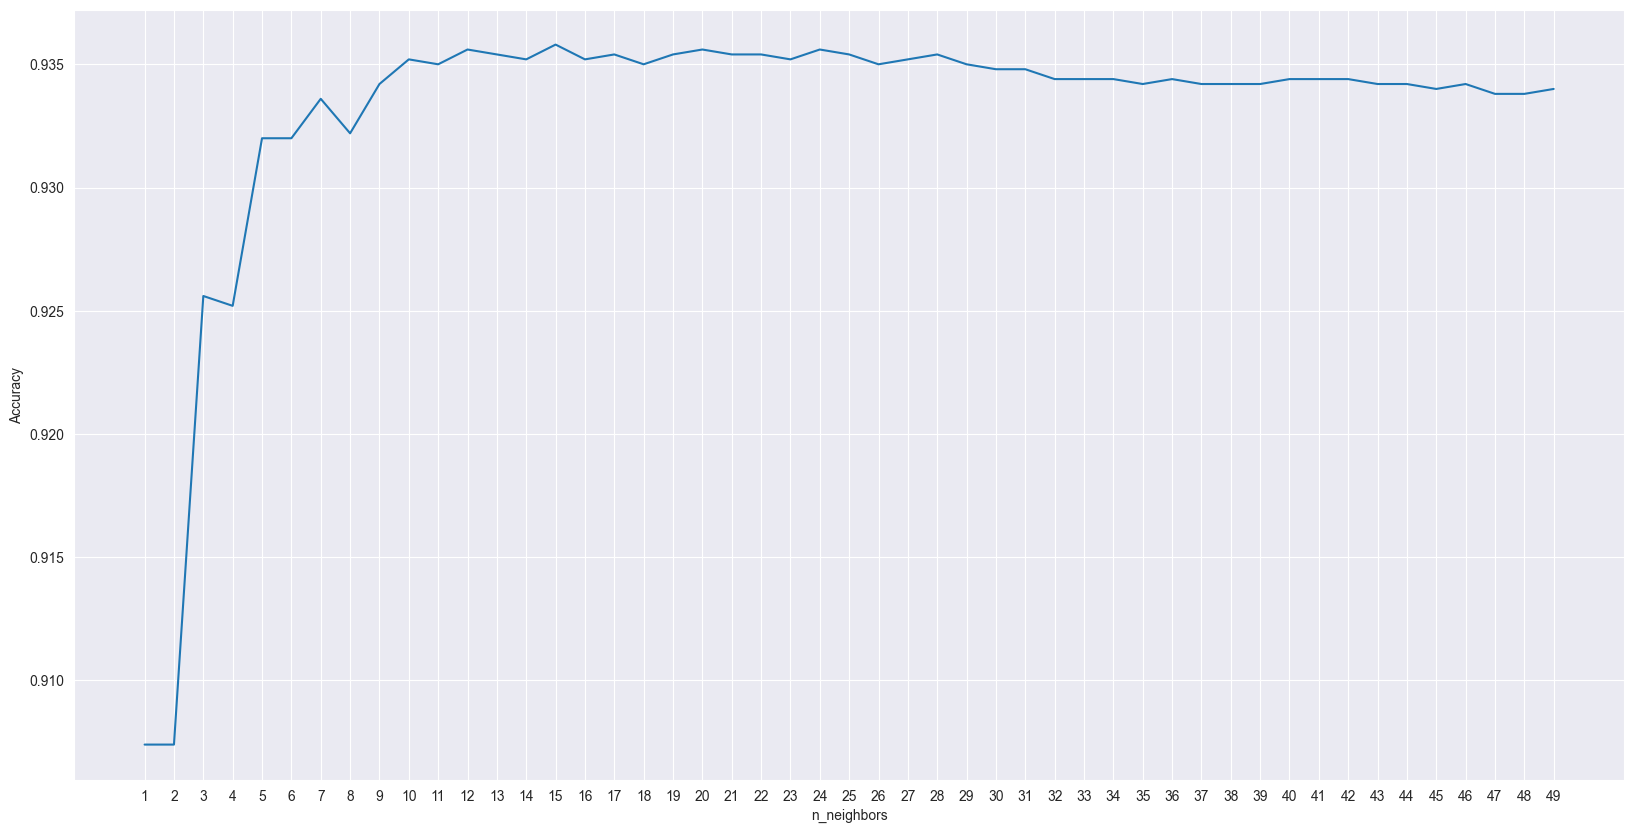

In [117]:
# Hyperparameter tuning

# Create a list of values for the hyperparameter
n_neighbors = list(range(1, 50))
scores = list()

# Create a classifier object with hyperparameter candidates
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(knn_train.drop(columns=['explicit']), knn_train['explicit'])
    scores.append(knn.score(knn_test.drop(columns=['explicit']), knn_test['explicit']))

# Plot the accuracy score for each value of n_neighbors, i want a large image
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [118]:
#print the best score
print(max(scores))

0.9358


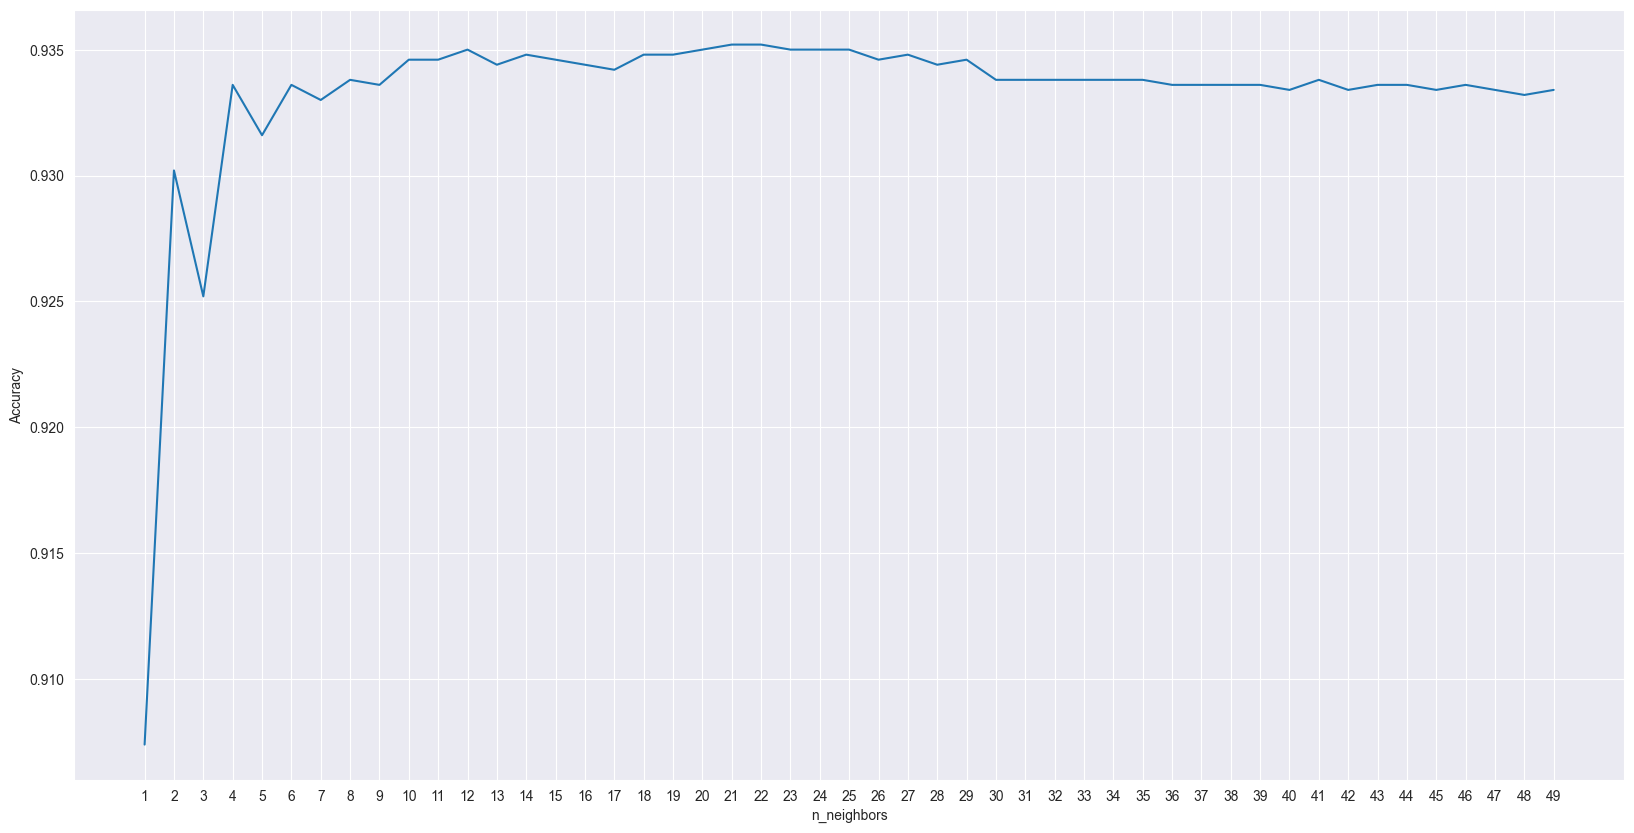

In [119]:
#Hyperparameter tuning

# Create a list of values for the hyperparameter
n_neighbors = list(range(1, 50))
scores = list()

# Create a classifier object with hyperparameter candidates
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(knn_train.drop(columns=['explicit']), knn_train['explicit'])
    scores.append(knn.score(knn_test.drop(columns=['explicit']), knn_test['explicit']))

# Plot the accuracy score for each value of n_neighbors, i want a large image
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

### Grid Search

In [121]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

In [125]:
param_grid = {
    "n_neighbors" : np.arange(1, 50),
    "weights" : ['uniform', 'distance'],
    "metric" : ['euclidean', 'manhattan', 'minkowski', 'cityblock']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=RepeatedStratifiedKFold(random_state=0), verbose=2, n_jobs=-1, refit=True)

grid.fit(knn_train.drop(columns=['explicit']), knn_train['explicit'])
clf = grid.best_estimator_

Fitting 50 folds for each of 392 candidates, totalling 19600 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.8s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.8s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1

In [126]:
print(grid.best_params_, grid.best_score_)

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'} 0.9368799999999999


In [131]:
#Predict genre for the test set
results = pd.DataFrame(grid.cv_results_)
results["metric_weight"] = results["param_metric"] + "," + results["param_weights"]

<AxesSubplot: xlabel='param_n_neighbors', ylabel='mean_test_score'>

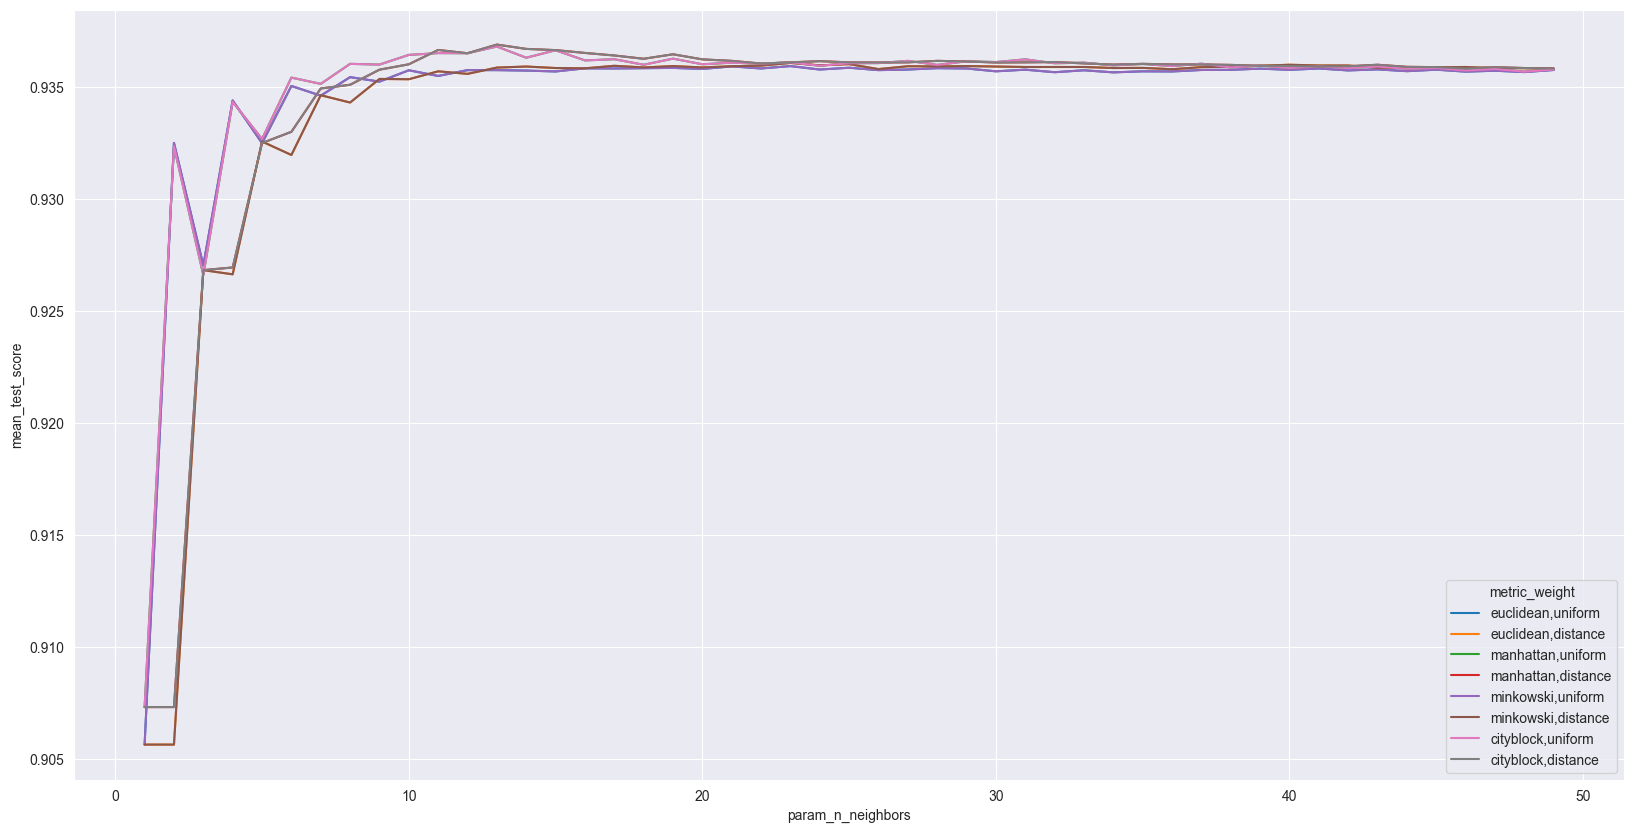

In [133]:
#Plot the results, big image
plt.figure(figsize=(20, 10))
sns.lineplot(data=results, x="param_n_neighbors", y="mean_test_score", hue="metric_weight")

In [136]:
knn_train 

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,0.056710,False,0.489362,0.704082,0.513,0.454545,0.702298,1.0,0.103834,0.303213,0.536000,0.282696,0.638191,0.644920,0.056710,0.8,0.077164,0.064977,0.160046,0.000000
1,0.105897,False,0.000000,0.070408,0.196,0.090909,0.469376,0.0,0.085729,0.284137,0.934000,0.362173,0.033769,0.342800,0.105897,0.8,0.083968,0.071429,0.487891,0.052632
2,0.079024,False,0.031915,0.370408,0.854,0.181818,0.798793,1.0,0.042279,0.000090,0.800000,0.263581,0.491457,0.528865,0.079024,0.8,0.088732,0.074654,0.889543,0.105263
3,0.063530,False,0.244681,0.533673,0.585,0.454545,0.833678,1.0,0.081470,0.066667,0.001270,0.117706,0.386935,0.638839,0.063530,0.8,0.084241,0.071429,0.160046,0.157895
4,0.072736,False,0.265957,0.656122,0.687,0.636364,0.724866,1.0,0.057401,0.000578,0.096900,0.300805,0.640201,0.652788,0.072736,0.8,0.099755,0.084332,1.000000,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.102985,False,0.000000,0.565306,0.657,0.090909,0.669976,1.0,0.059425,0.016064,0.615000,0.132797,0.033668,0.531999,0.102985,0.8,0.113909,0.097696,0.487891,0.789474
14996,0.042357,False,0.468085,0.105102,0.860,0.090909,0.567578,1.0,0.063365,0.550201,0.940000,0.123742,0.001608,0.418651,0.042357,0.6,0.037697,0.042396,0.487891,0.421053
14997,0.095218,False,0.457447,0.815306,0.535,0.090909,0.767324,1.0,0.063259,0.001837,0.857000,0.071730,0.071156,0.571364,0.095218,0.8,0.113909,0.096313,0.487891,0.473684
14998,0.045885,False,0.393617,0.521429,0.970,0.454545,0.896464,1.0,0.056550,0.000338,0.000014,0.404427,0.271357,0.725741,0.045885,0.8,0.069815,0.059908,0.160046,1.000000


In [137]:
# Using oversampling and SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE


X_train = knn_train.drop('explicit', axis=1)
y_train = knn_train['explicit']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [146]:
X_train_smote

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,0.056710,0.489362,0.704082,0.513000,0.454545,0.702298,1.0,0.103834,0.303213,0.536000,0.282696,0.638191,0.644920,0.056710,0.800000,0.077164,0.064977,0.160046,0.000000
1,0.105897,0.000000,0.070408,0.196000,0.090909,0.469376,0.0,0.085729,0.284137,0.934000,0.362173,0.033769,0.342800,0.105897,0.800000,0.083968,0.071429,0.487891,0.052632
2,0.079024,0.031915,0.370408,0.854000,0.181818,0.798793,1.0,0.042279,0.000090,0.800000,0.263581,0.491457,0.528865,0.079024,0.800000,0.088732,0.074654,0.889543,0.105263
3,0.063530,0.244681,0.533673,0.585000,0.454545,0.833678,1.0,0.081470,0.066667,0.001270,0.117706,0.386935,0.638839,0.063530,0.800000,0.084241,0.071429,0.160046,0.157895
4,0.072736,0.265957,0.656122,0.687000,0.636364,0.724866,1.0,0.057401,0.000578,0.096900,0.300805,0.640201,0.652788,0.072736,0.800000,0.099755,0.084332,1.000000,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,0.067831,0.178651,0.486484,0.991586,1.000000,0.892244,0.0,0.399268,0.031888,0.044787,0.149309,0.192742,0.805424,0.067831,0.720682,0.115110,0.106045,0.000000,0.210526
28064,0.063985,0.082786,0.821340,0.729873,0.090909,0.835596,1.0,0.067097,0.001019,0.731477,0.054880,0.297538,0.566830,0.063985,0.800000,0.076353,0.064330,0.487891,0.894737
28065,0.057010,0.401300,0.519292,0.767701,0.898212,0.820613,1.0,0.051905,0.008622,0.005851,0.137984,0.488468,0.729972,0.057009,0.800000,0.088865,0.074883,0.100437,0.705351
28066,0.039161,0.587057,0.660965,0.664669,0.781602,0.793546,0.0,0.177114,0.056463,0.000085,0.271527,0.630371,0.613814,0.039161,0.719525,0.052896,0.053031,0.346995,0.915915


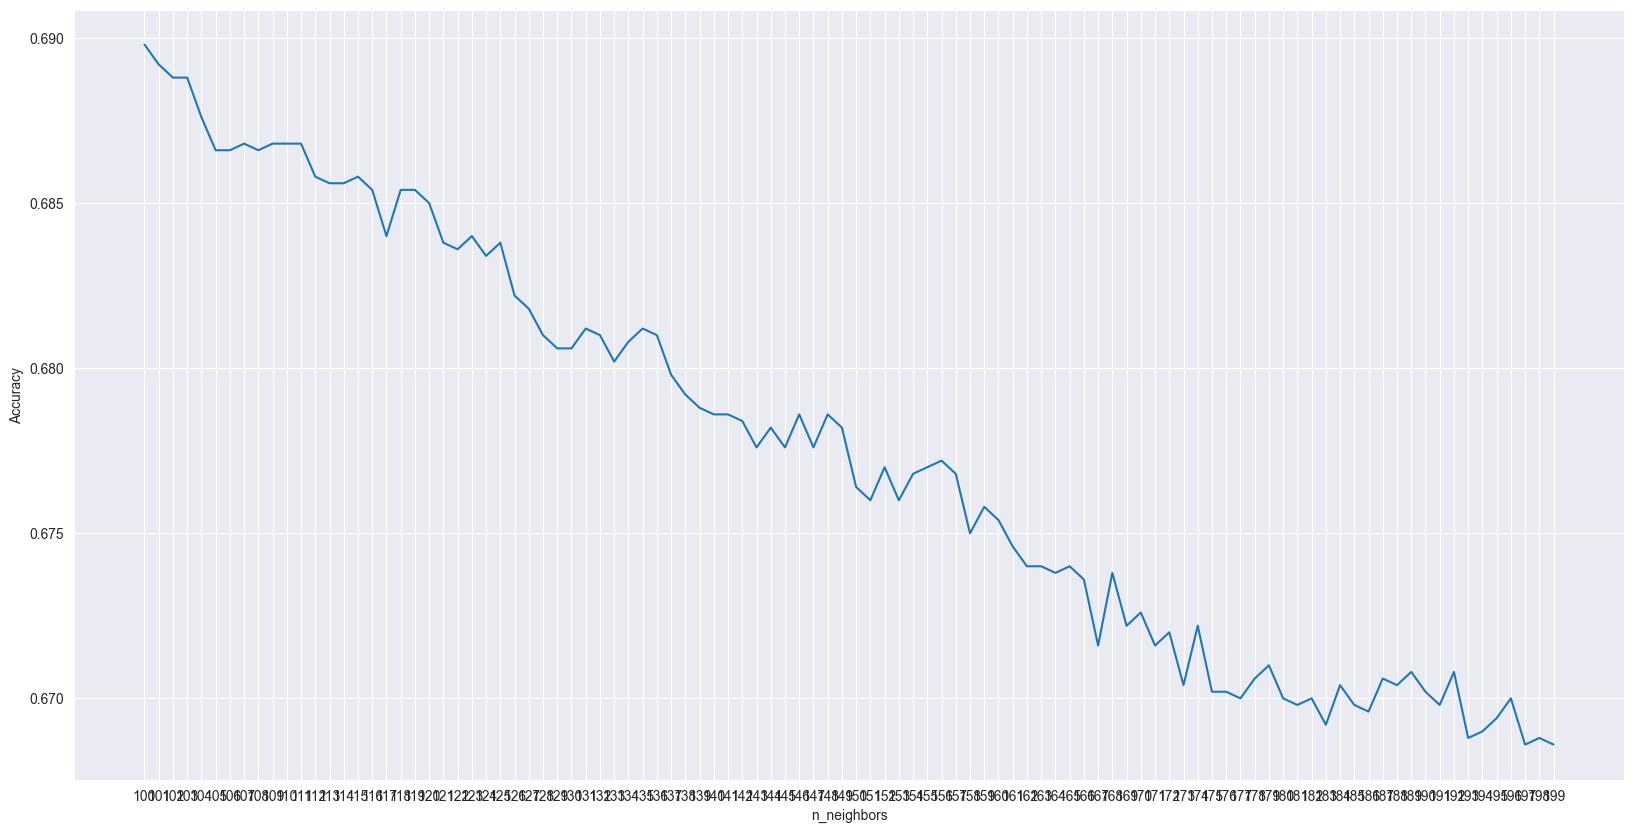

In [145]:
# Hyperparameter tuning

# Create a list of values for the hyperparameter
n_neighbors = list(range(1, 50))
scores = list()

# Create a classifier object with hyperparameter candidates
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train_smote, y_train_smote)
    scores.append(knn.score(knn_test.drop(columns=['explicit']), knn_test['explicit']))

# Plot the accuracy score for each value of n_neighbors, i want a large image
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

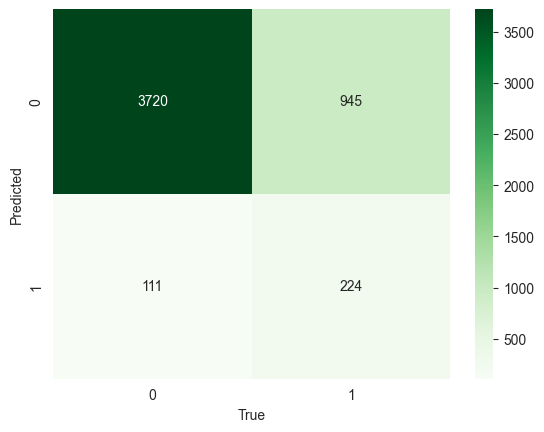

In [150]:
#confusion matrix
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train_smote, y_train_smote)
y_pred = knn.predict(knn_test.drop(columns=['explicit']))
cf = confusion_matrix(knn_test['explicit'], y_pred)
sns.heatmap(cf, annot=True, cmap='Greens', fmt='d')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()


In [149]:
print(classification_report(knn_test['explicit'], y_pred))

              precision    recall  f1-score   support

       False       0.97      0.80      0.88      4665
        True       0.19      0.67      0.30       335

    accuracy                           0.79      5000
   macro avg       0.58      0.73      0.59      5000
weighted avg       0.92      0.79      0.84      5000


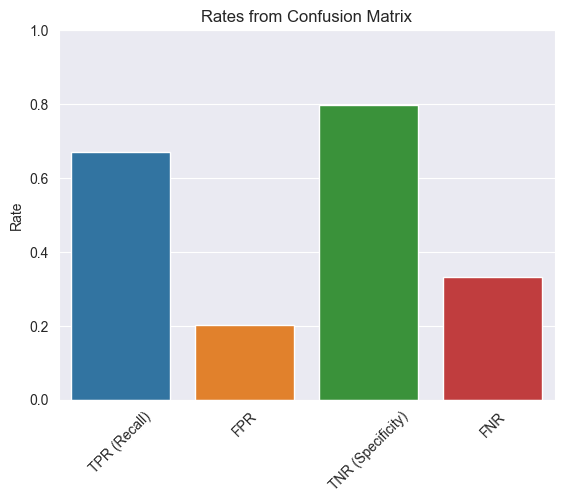

In [155]:
# Plot true positive rate, false positive rate, precision and recall
# Assuming 'cf' is the confusion matrix you have computed
TP = cf[1, 1]
TN = cf[0, 0]
FP = cf[0, 1]
FN = cf[1, 0]

# Calculate rates
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
TNR = TN / (TN + FP)
FNR = FN / (TP + FN)

# Create a bar plot for the rates
rates = {'TPR (Recall)': TPR, 'FPR': FPR, 'TNR (Specificity)': TNR, 'FNR': FNR}
names = list(rates.keys())
values = list(rates.values())

sns.barplot(x=names, y=values)
plt.title('Rates from Confusion Matrix')
plt.ylabel('Rate')
plt.ylim(0, 1)  # Limit y-axis to [0, 1] for rate representation
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()